In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-life/dataset/EMA/EMA_definition.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u31.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u36.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u20.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u22.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u07.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u05.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u51.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u27.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u56.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u23.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u09.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u54.json
/kaggle/input/student-life/dataset/EMA/response/Stress/Stress_u15.json
/kaggle/input/stud

# STUDENTLIFE ANALYSIS
# Joint Dataset Creation, VAR, and ARX Models

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("All packages imported successfully!")

All packages imported successfully!


In [23]:
# load dataset

def load_phone_sensing_data(base_path='/kaggle/input/student-life/dataset/sensing'):
    """
    Load and aggregate phone sensing data
    Columns are 'start' and 'end' (not 'start_timestamp' and 'duration')
    """
    import glob
    
    all_data = []
    
    # Load phonelock data
    phonelock_files = glob.glob(f'{base_path}/phonelock/*.csv')
    print(f"Found {len(phonelock_files)} phonelock files")
    
    for file in phonelock_files:
        user_id = file.split('_')[-1].replace('.csv', '')
        try:
            df = pd.read_csv(file)
            
            if len(df) > 0 and 'start' in df.columns and 'end' in df.columns:
                # Calculate duration from start and end
                df['duration'] = df['end'] - df['start']
                df['user_id'] = user_id
                df['date'] = pd.to_datetime(df['start'], unit='s').dt.date
                
                # Aggregate by user and date
                daily = df.groupby(['user_id', 'date']).agg({
                    'start': 'count',  # number of lock intervals
                    'duration': 'sum'  # total lock duration in seconds
                }).reset_index()
                
                daily.columns = ['user_id', 'date', 'phonelock_n_intervals', 'phonelock_duration_sec']
                all_data.append(daily)
                
        except Exception as e:
            continue
    
    print(f"Successfully loaded {len(all_data)} users")
    
    # Combine all users
    if all_data:
        phone_data = pd.concat(all_data, ignore_index=True)
        phone_data['date'] = pd.to_datetime(phone_data['date'])
        return phone_data
    else:
        return pd.DataFrame()


def load_ema_data(base_path='/kaggle/input/student-life/dataset/EMA/response'):
    """
    Load EMA data - PAM files have 'picture_idx' not 'mood'
    """
    import glob
    import json
    
    ema_data = []
    
    # PAM (mood) data - picture_idx is the mood value
    pam_files = glob.glob(f'{base_path}/PAM/*.json')
    print(f"Found {len(pam_files)} PAM files")
    
    for file in pam_files:
        user_id = file.split('_')[-1].replace('.json', '')
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                
                for entry in data:
                    if 'resp_time' in entry and 'picture_idx' in entry:
                        date = pd.to_datetime(entry['resp_time'], unit='s').date()
                        try:
                            # picture_idx is the mood indicator (1-16)
                            mood_val = pd.to_numeric(entry['picture_idx'], errors='coerce')
                            if not pd.isna(mood_val):
                                ema_data.append({
                                    'user_id': user_id,
                                    'date': date,
                                    'category': 'pam_mean',
                                    'value': mood_val
                                })
                        except:
                            continue
        except:
            continue
    
    # Stress data  
    stress_files = glob.glob(f'{base_path}/Stress/*.json')
    print(f"Found {len(stress_files)} Stress files")
    
    for file in stress_files:
        user_id = file.split('_')[-1].replace('.json', '')
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                
                for entry in data:
                    if 'resp_time' in entry and 'level' in entry:
                        date = pd.to_datetime(entry['resp_time'], unit='s').date()
                        try:
                            stress_val = pd.to_numeric(entry['level'], errors='coerce')
                            if not pd.isna(stress_val):
                                ema_data.append({
                                    'user_id': user_id,
                                    'date': date,
                                    'category': 'stress_level',
                                    'value': stress_val
                                })
                        except:
                            continue
        except:
            continue
    
    print(f"Collected {len(ema_data)} EMA responses")
    
    # Convert to DataFrame
    if ema_data:
        df = pd.DataFrame(ema_data)
        df['date'] = pd.to_datetime(df['date'])
        
        # Group and take mean for each user-date-category
        ema_agg = df.groupby(['user_id', 'date', 'category'])['value'].mean().reset_index()
        
        # Pivot to have one column per category
        ema_pivot = ema_agg.pivot_table(
            index=['user_id', 'date'],
            columns='category',
            values='value',
            aggfunc='first'
        ).reset_index()
        
        ema_pivot.columns.name = None
        return ema_pivot
    else:
        return pd.DataFrame()


## Feature engineering 

In [24]:
def engineer_features(df):
    """
    Create behavioral features from phone sensing data
    """
    df = df.copy()
    
    # Unlock frequency (unlocks per hour)
    df['unlock_rate'] = df['phonelock_n_intervals'] / 24
    
    # Average session length in seconds and minutes
    df['avg_session_sec'] = df['phonelock_duration_sec'] / df['phonelock_n_intervals']
    df['avg_session_min'] = df['avg_session_sec'] / 60
    
    # Temporal features
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['week_of_study'] = ((df['date'] - df['date'].min()).dt.days // 7) + 1
    
    return df


## Merge Joint Dataset

In [25]:

def create_joint_dataset():
    """
    Load all data and create joint dataset
    """
    print("Loading phone sensing data...")
    phone_data = load_phone_sensing_data()
    
    if len(phone_data) > 0:
        print(f"✓ Loaded {len(phone_data)} phone records from {phone_data['user_id'].nunique()} users")
    else:
        print(" No phone data loaded")
        return pd.DataFrame()
    
    print("\nLoading EMA data...")
    ema_data = load_ema_data()
    
    if len(ema_data) > 0:
        print(f"✓ Loaded {len(ema_data)} EMA records from {ema_data['user_id'].nunique()} users")
    else:
        print(" No EMA data loaded")
    
    # Merge datasets
    print("\nMerging datasets...")
    joint_data = pd.merge(
        phone_data,
        ema_data,
        on=['user_id', 'date'],
        how='outer'
    )
    
    print(f"Joint dataset: {joint_data.shape}")
    print(f"Date range: {joint_data['date'].min()} to {joint_data['date'].max()}")
    print(f"Users: {joint_data['user_id'].nunique()}")
    
    # Engineer features
    print("\nEngineering features...")
    joint_data = engineer_features(joint_data)
    
    # Sort
    joint_data = joint_data.sort_values(['user_id', 'date']).reset_index(drop=True)
    
    return joint_data


# Run data loading
print("="*80)
print("CREATING JOINT DATASET")
print("="*80)

joint_df = create_joint_dataset()

if len(joint_df) > 0:
    # Save
    joint_df.to_csv('studentlife_timeseries_ready.csv', index=False)
    print("\n✓ Dataset saved to: studentlife_timeseries_ready.csv")
    
    # Summary
    print("\n" + "="*80)
    print("DATASET SUMMARY")
    print("="*80)
    print(joint_df[['unlock_rate', 'avg_session_min', 'pam_mean']].describe())
    
    print("\n" + "="*80)
    print("MISSING DATA")
    print("="*80)
    missing_pct = (joint_df.isnull().sum() / len(joint_df) * 100).sort_values(ascending=False)
    print(missing_pct[missing_pct > 0].head(10))
else:
    print("\n Failed to create dataset")


CREATING JOINT DATASET
Loading phone sensing data...
Found 49 phonelock files
Successfully loaded 49 users
✓ Loaded 2538 phone records from 49 users

Loading EMA data...
Found 49 PAM files
Found 49 Stress files
Collected 11207 EMA responses
✓ Loaded 2300 EMA records from 49 users

Merging datasets...
Joint dataset: (2838, 6)
Date range: 2013-03-24 00:00:00 to 2013-08-16 00:00:00
Users: 49

Engineering features...

✓ Dataset saved to: studentlife_timeseries_ready.csv

DATASET SUMMARY
       unlock_rate  avg_session_min     pam_mean
count  2538.000000      2538.000000  2296.000000
mean      0.152269       199.080245     8.858776
std       0.078800        94.748196     2.923991
min       0.041667        60.533333     1.000000
25%       0.083333       133.079167     7.000000
50%       0.125000       181.014583     8.833333
75%       0.208333       241.610833    11.000000
max       0.416667       598.400000    16.000000

MISSING DATA
stress_level              56.166314
pam_mean             

In [26]:
# stationary testing 

def test_stationarity(timeseries, name='Series'):
    """
    Perform Augmented Dickey-Fuller test
    """
    ts_clean = timeseries.dropna()
    
    if len(ts_clean) < 10:
        print(f"Not enough data for {name} (n={len(ts_clean)})")
        return False
    
    result = adfuller(ts_clean, autolag='AIC')
    
    print(f'\n{"="*70}')
    print(f'Stationarity Test: {name}')
    print(f'{"="*70}')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"✓ STATIONARY")
        return True
    else:
        print(f"✗ NON-STATIONARY")
        return False


if len(joint_df) > 0:
    print("\n" + "="*80)
    print("TESTING STATIONARITY")
    print("="*80)
    
    # Daily aggregates
    daily_agg = joint_df.groupby('date').agg({
        'unlock_rate': 'mean',
        'avg_session_min': 'mean',
        'pam_mean': 'mean'
    }).reset_index()
    
    print(f"Daily data: {len(daily_agg)} days")
    
    unlock_stationary = test_stationarity(daily_agg['unlock_rate'], 'Unlock Rate')
    session_stationary = test_stationarity(daily_agg['avg_session_min'], 'Session Length')
    mood_stationary = test_stationarity(daily_agg['pam_mean'], 'Mood (PAM)')



TESTING STATIONARITY
Daily data: 83 days

Stationarity Test: Unlock Rate
ADF Statistic: 0.021970
p-value: 0.960312
Critical Values:
	1%: -3.541
	5%: -2.909
	10%: -2.592
✗ NON-STATIONARY

Stationarity Test: Session Length
ADF Statistic: -10.640480
p-value: 0.000000
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590
✓ STATIONARY

Stationarity Test: Mood (PAM)
ADF Statistic: -7.197945
p-value: 0.000000
Critical Values:
	1%: -3.517
	5%: -2.899
	10%: -2.587
✓ STATIONARY


In [27]:
# Data detrending 
def detrend_series(series):
    """Remove linear trend"""
    clean_series = series.dropna()
    if len(clean_series) > 0:
        return signal.detrend(clean_series)
    else:
        return np.array([])


if len(joint_df) > 0:
    print("\n" + "="*80)
    print("DETRENDING")
    print("="*80)
    
    daily_agg['unlock_detrend'] = np.nan
    daily_agg['session_detrend'] = np.nan
    
    unlock_clean = daily_agg['unlock_rate'].dropna()
    if len(unlock_clean) > 0:
        daily_agg.loc[unlock_clean.index, 'unlock_detrend'] = detrend_series(unlock_clean)
        print("✓ Unlock rate detrended")
    
    session_clean = daily_agg['avg_session_min'].dropna()
    if len(session_clean) > 0:
        daily_agg.loc[session_clean.index, 'session_detrend'] = detrend_series(session_clean)
        print("✓ Session length detrended")




DETRENDING
✓ Unlock rate detrended
✓ Session length detrended


## ARX model

In [28]:

if len(joint_df) > 0:
    print("\n" + "="*80)
    print("ARX MODEL")
    print("="*80)
    
    user_counts = joint_df.groupby('user_id').size()
    good_users = user_counts[user_counts >= 15].index.tolist()
    
    print(f"Users with ≥15 observations: {len(good_users)}")
    
    if len(good_users) > 0:
        test_user = good_users[0]
        user_data = joint_df[joint_df['user_id'] == test_user].copy()
        user_data = user_data.sort_values('date').reset_index(drop=True)
        
        arx_data = user_data[['pam_mean', 'unlock_rate']].dropna()
        
        if len(arx_data) > 10:
            print(f"\nUser {test_user} (n={len(arx_data)})")
            
            arx_df = pd.DataFrame({
                'mood_t': arx_data['pam_mean'].values[1:],
                'mood_lag1': arx_data['pam_mean'].values[:-1],
                'unlock_lag1': arx_data['unlock_rate'].values[:-1]
            })
            
            X_matrix = add_constant(arx_df[['mood_lag1', 'unlock_lag1']])
            y_vector = arx_df['mood_t']
            
            arx_model = OLS(y_vector, X_matrix).fit()
            
            print("\n" + "="*70)
            print("ARX(1) RESULTS")
            print("="*70)
            print(arx_model.summary())
            
            print("\n" + "="*70)
            print("INTERPRETATION")
            print("="*70)
            print(f"Mood persistence: {arx_model.params['mood_lag1']:.4f} (p={arx_model.pvalues['mood_lag1']:.4f})")
            print(f"Unlock effect: {arx_model.params['unlock_lag1']:.4f} (p={arx_model.pvalues['unlock_lag1']:.4f})")
            
            if arx_model.pvalues['unlock_lag1'] < 0.05:
                print("\n✓ Unlock rate SIGNIFICANTLY predicts mood")
            else:
                print("\n✗ Unlock rate does NOT significantly predict mood")




ARX MODEL
Users with ≥15 observations: 48

User u00 (n=59)

ARX(1) RESULTS
                            OLS Regression Results                            
Dep. Variable:                 mood_t   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.3920
Date:                Wed, 17 Dec 2025   Prob (F-statistic):              0.678
Time:                        07:05:17   Log-Likelihood:                -117.22
No. Observations:                  58   AIC:                             240.4
Df Residuals:                      55   BIC:                             246.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

## VAR model

In [29]:

if len(joint_df) > 0:
    print("\n" + "="*80)
    print("VAR MODEL")
    print("="*80)
    
    var_data = daily_agg[['unlock_detrend', 'pam_mean']].dropna()
    
    print(f"VAR data: {var_data.shape}")
    
    if len(var_data) > 20:
        print("\nFitting VAR model...")
        var_model = VAR(var_data)
        
        try:
            var_results = var_model.fit(maxlags=5, ic='aic')
            
            print(f"\n✓ Optimal lag order: {var_results.k_ar}")
            print("\n" + "="*70)
            print("GRANGER CAUSALITY")
            print("="*70)
            
            print("\n1. Unlock → Mood")
            gc1 = var_results.test_causality('pam_mean', 'unlock_detrend', kind='f')
            print(gc1)
            
            print("\n2. Mood → Unlock")
            gc2 = var_results.test_causality('unlock_detrend', 'pam_mean', kind='f')
            print(gc2)
            
            # IRF plots
            irf = var_results.irf(10)
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            irf.plot(impulse='unlock_detrend', response='pam_mean', ax=axes[0, 0])
            axes[0, 0].set_title('Unlock → Mood')
            
            irf.plot(impulse='pam_mean', response='unlock_detrend', ax=axes[0, 1])
            axes[0, 1].set_title('Mood → Unlock')
            
            irf.plot(impulse='unlock_detrend', response='unlock_detrend', ax=axes[1, 0])
            axes[1, 0].set_title('Unlock → Unlock')
            
            irf.plot(impulse='pam_mean', response='pam_mean', ax=axes[1, 1])
            axes[1, 1].set_title('Mood → Mood')
            
            plt.tight_layout()
            plt.savefig('var_impulse_response.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("\n✓ IRF saved: var_impulse_response.png")
            
        except Exception as e:
            print(f"✗ Error: {e}")


VAR MODEL
VAR data: (68, 2)

Fitting VAR model...

✓ Optimal lag order: 0

GRANGER CAUSALITY

1. Unlock → Mood
✗ Error: Cannot test Granger Causality in a model with 0 lags.


## Multi-user VAR

In [30]:

if len(joint_df) > 0 and len(good_users) > 0:
    print("\n" + "="*80)
    print("MULTI-USER VAR")
    print("="*80)
    
    user_var_results = []
    
    for user_id in good_users[:5]:
        user_data = joint_df[joint_df['user_id'] == user_id].copy()
        user_data = user_data.sort_values('date')
        user_var = user_data[['unlock_rate', 'pam_mean']].dropna()
        
        if len(user_var) >= 15:
            print(f"\nUser {user_id} (n={len(user_var)})")
            
            try:
                model = VAR(user_var)
                results = model.fit(maxlags=3, ic='aic')
                
                gc1 = results.test_causality('pam_mean', 'unlock_rate', kind='f')
                gc2 = results.test_causality('unlock_rate', 'pam_mean', kind='f')
                
                user_var_results.append({
                    'user_id': user_id,
                    'n_obs': len(user_var),
                    'lag_order': results.k_ar,
                    'p_unlock_to_mood': gc1.pvalue,
                    'p_mood_to_unlock': gc2.pvalue,
                    'unlock_causes_mood': gc1.pvalue < 0.05,
                    'mood_causes_unlock': gc2.pvalue < 0.05
                })
                
                print(f"  Unlock → Mood: p={gc1.pvalue:.4f}")
                print(f"  Mood → Unlock: p={gc2.pvalue:.4f}")
                
            except Exception as e:
                print(f"  Error: {e}")
    
    if user_var_results:
        results_df = pd.DataFrame(user_var_results)
        print("\n" + "="*70)
        print("SUMMARY")
        print("="*70)
        print(results_df.to_string(index=False))
        
        print(f"\nUnlock causes Mood: {results_df['unlock_causes_mood'].sum()} / {len(results_df)}")
        print(f"Mood causes Unlock: {results_df['mood_causes_unlock'].sum()} / {len(results_df)}")
        
        results_df.to_csv('var_granger_results.csv', index=False)
        print("\n✓ Saved: var_granger_results.csv")


print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


MULTI-USER VAR

User u00 (n=59)
  Error: Cannot test Granger Causality in a model with 0 lags.

User u01 (n=41)
  Error: Cannot test Granger Causality in a model with 0 lags.

User u02 (n=56)
  Error: Cannot test Granger Causality in a model with 0 lags.

User u03 (n=31)
  Error: Cannot test Granger Causality in a model with 0 lags.

User u04 (n=48)
  Unlock → Mood: p=0.9700
  Mood → Unlock: p=0.2060

SUMMARY
user_id  n_obs  lag_order  p_unlock_to_mood  p_mood_to_unlock  unlock_causes_mood  mood_causes_unlock
    u04     48          2          0.969998          0.206004               False               False

Unlock causes Mood: 0 / 1
Mood causes Unlock: 0 / 1

✓ Saved: var_granger_results.csv

ANALYSIS COMPLETE


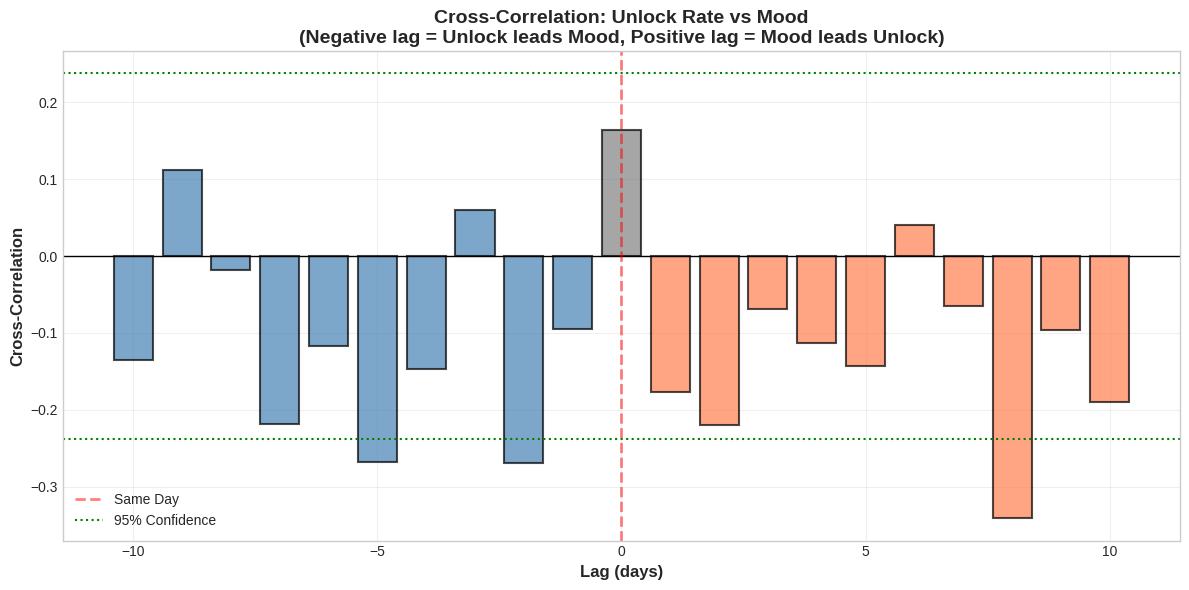

✓ Saved: cross_correlation.png


In [33]:
# ============================================================================
# CROSS-CORRELATION PLOT (MOOD VS UNLOCK RATE)
# ============================================================================

# Calculate cross-correlation at different lags
from statsmodels.tsa.stattools import ccf

# Get clean data
unlock_clean = daily_trends['unlock_rate'].dropna()
mood_clean = daily_trends['pam_mean'].dropna()

# Align lengths
min_len = min(len(unlock_clean), len(mood_clean))
unlock_clean = unlock_clean.iloc[:min_len].values
mood_clean = mood_clean.iloc[:min_len].values

# Calculate cross-correlation
lags = range(-10, 11)
ccf_values = [np.corrcoef(unlock_clean[max(0, lag):min_len+min(0, lag)], 
                          mood_clean[max(0, -lag):min_len+min(0, -lag)])[0, 1] 
              for lag in lags]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['steelblue' if lag < 0 else 'coral' if lag > 0 else 'gray' for lag in lags]
ax.bar(lags, ccf_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Same Day')

# Add significance threshold (approximate)
threshold = 1.96 / np.sqrt(min_len)
ax.axhline(y=threshold, color='green', linestyle=':', linewidth=1.5, label='95% Confidence')
ax.axhline(y=-threshold, color='green', linestyle=':', linewidth=1.5)

ax.set_xlabel('Lag (days)', fontsize=12, fontweight='bold')
ax.set_ylabel('Cross-Correlation', fontsize=12, fontweight='bold')
ax.set_title('Cross-Correlation: Unlock Rate vs Mood\n(Negative lag = Unlock leads Mood, Positive lag = Mood leads Unlock)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cross_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: cross_correlation.png")


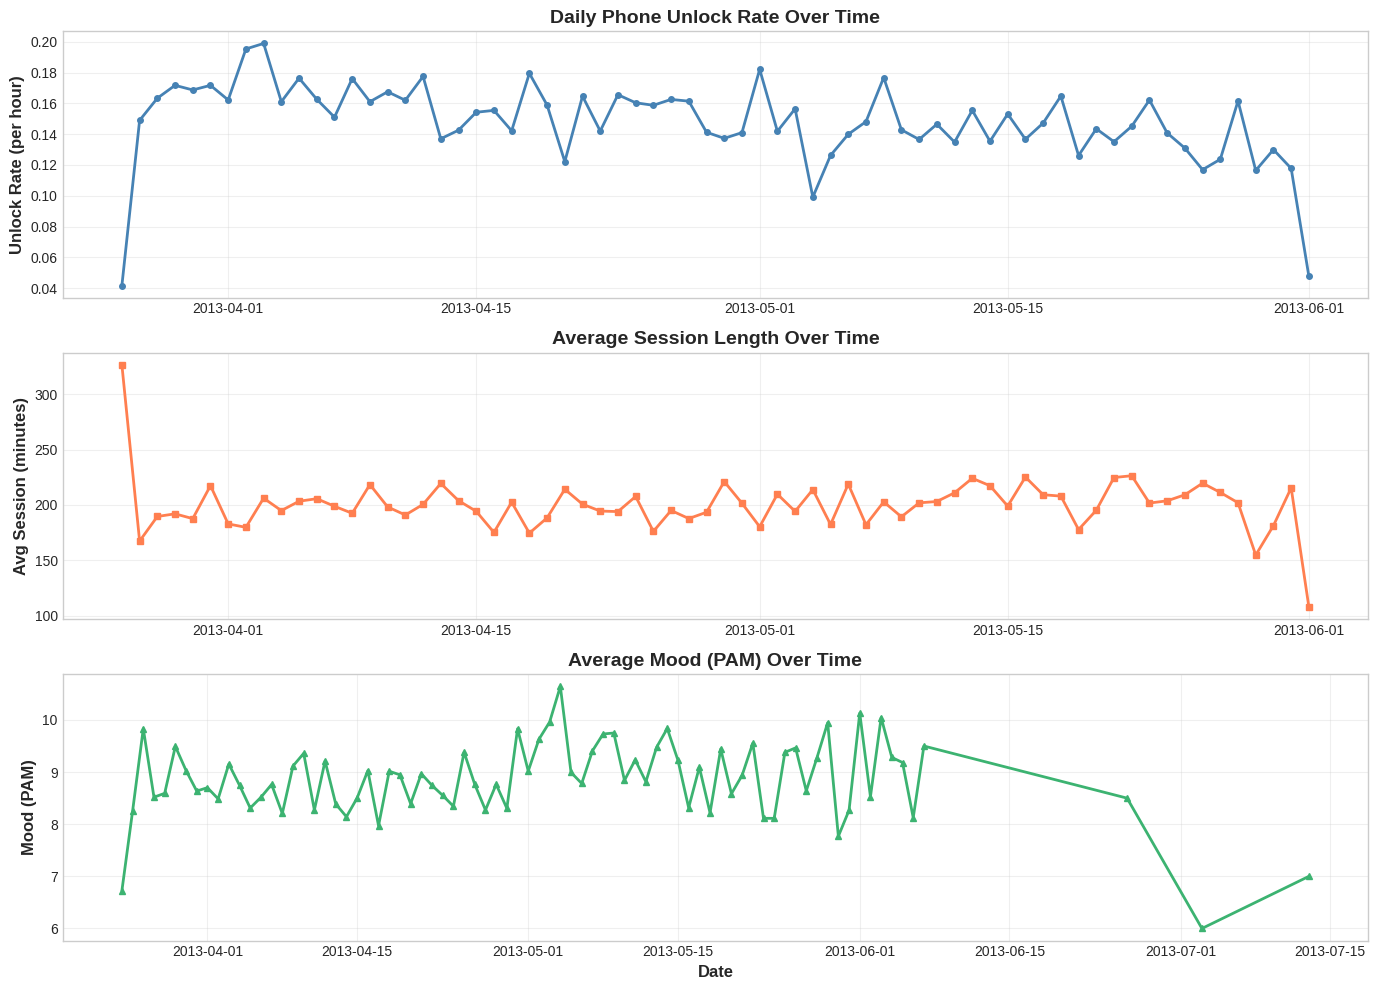

✓ Saved: time_series_trends.png


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# ============================================================================
# TIME SERIES PLOTS - MOOD AND PHONE USAGE OVER TIME
# ============================================================================

# Aggregate daily across all users
daily_trends = joint_df.groupby('date').agg({
    'unlock_rate': 'mean',
    'avg_session_min': 'mean',
    'pam_mean': 'mean'
}).reset_index()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Unlock rate over time
axes[0].plot(daily_trends['date'], daily_trends['unlock_rate'], 
             color='steelblue', linewidth=2, marker='o', markersize=4)
axes[0].set_ylabel('Unlock Rate (per hour)', fontsize=12, fontweight='bold')
axes[0].set_title('Daily Phone Unlock Rate Over Time', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Session length over time
axes[1].plot(daily_trends['date'], daily_trends['avg_session_min'], 
             color='coral', linewidth=2, marker='s', markersize=4)
axes[1].set_ylabel('Avg Session (minutes)', fontsize=12, fontweight='bold')
axes[1].set_title('Average Session Length Over Time', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Mood over time
axes[2].plot(daily_trends['date'], daily_trends['pam_mean'], 
             color='mediumseagreen', linewidth=2, marker='^', markersize=4)
axes[2].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Mood (PAM)', fontsize=12, fontweight='bold')
axes[2].set_title('Average Mood (PAM) Over Time', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('time_series_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: time_series_trends.png")


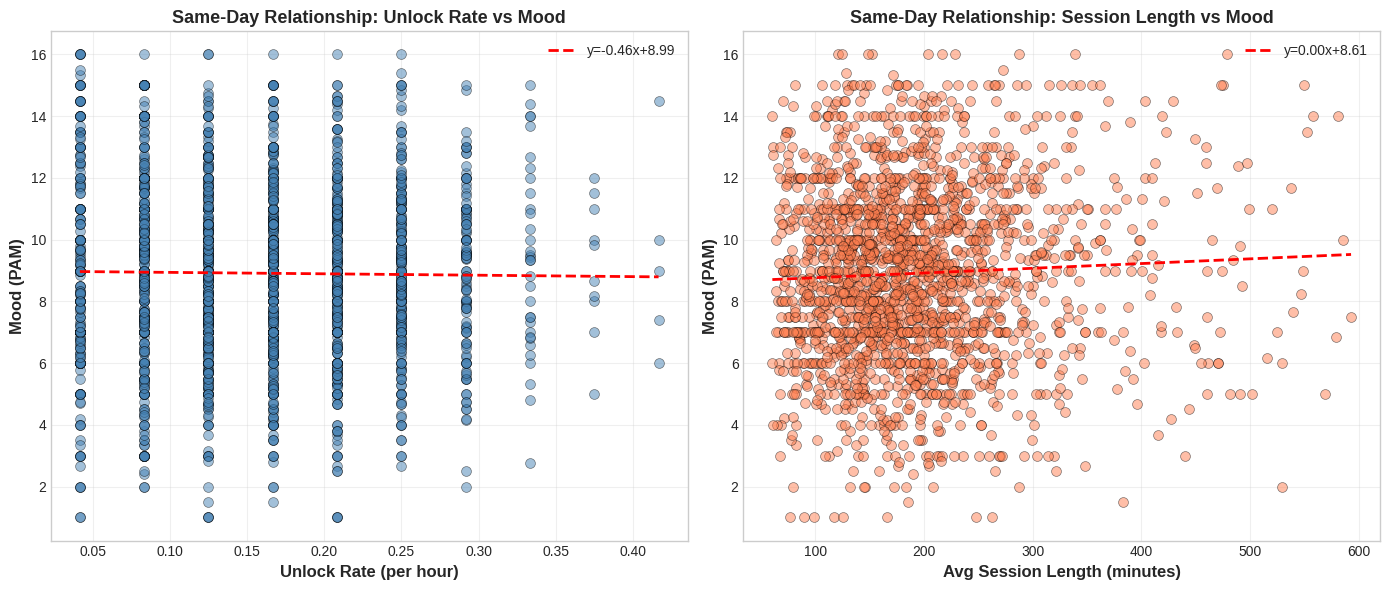

 Saved: scatter_relationships.png


In [35]:
# ============================================================================
# SCATTER PLOTS WITH REGRESSION LINES
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Unlock rate vs Mood (same day)
user_daily = joint_df[['unlock_rate', 'pam_mean']].dropna()

axes[0].scatter(user_daily['unlock_rate'], user_daily['pam_mean'], 
                alpha=0.5, s=50, c='steelblue', edgecolors='black', linewidth=0.5)
z = np.polyfit(user_daily['unlock_rate'], user_daily['pam_mean'], 1)
p = np.poly1d(z)
axes[0].plot(user_daily['unlock_rate'].sort_values(), 
             p(user_daily['unlock_rate'].sort_values()), 
             "r--", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].set_xlabel('Unlock Rate (per hour)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mood (PAM)', fontsize=12, fontweight='bold')
axes[0].set_title('Same-Day Relationship: Unlock Rate vs Mood', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Session length vs Mood
user_daily2 = joint_df[['avg_session_min', 'pam_mean']].dropna()

axes[1].scatter(user_daily2['avg_session_min'], user_daily2['pam_mean'], 
                alpha=0.5, s=50, c='coral', edgecolors='black', linewidth=0.5)
z2 = np.polyfit(user_daily2['avg_session_min'], user_daily2['pam_mean'], 1)
p2 = np.poly1d(z2)
axes[1].plot(user_daily2['avg_session_min'].sort_values(), 
             p2(user_daily2['avg_session_min'].sort_values()), 
             "r--", linewidth=2, label=f'y={z2[0]:.2f}x+{z2[1]:.2f}')
axes[1].set_xlabel('Avg Session Length (minutes)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mood (PAM)', fontsize=12, fontweight='bold')
axes[1].set_title('Same-Day Relationship: Session Length vs Mood', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scatter_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: scatter_relationships.png")


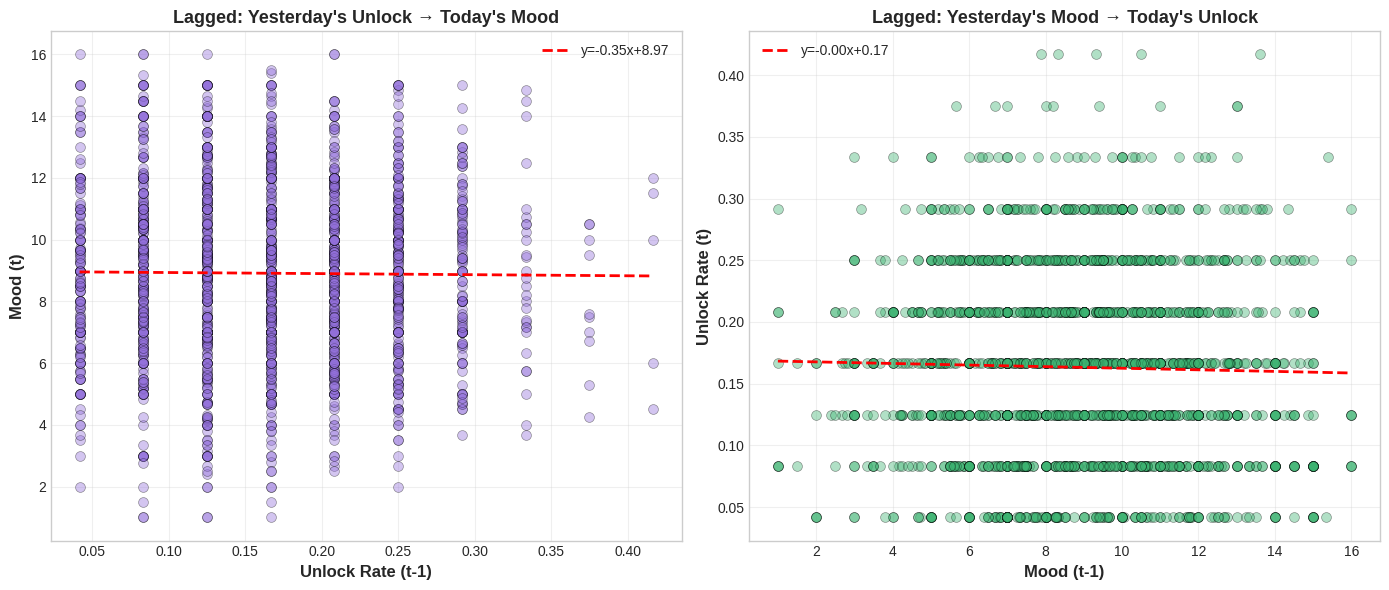

Saved: lagged_relationships.png


In [36]:

# ============================================================================
# LAGGED RELATIONSHIPS (Unlock t-1 → Mood t)
# ============================================================================

# Create lagged dataset
lagged_data = []
for user_id in joint_df['user_id'].unique():
    user_data = joint_df[joint_df['user_id'] == user_id].sort_values('date')
    user_data['unlock_lag1'] = user_data['unlock_rate'].shift(1)
    user_data['mood_lag1'] = user_data['pam_mean'].shift(1)
    lagged_data.append(user_data)

lagged_df = pd.concat(lagged_data, ignore_index=True)
lagged_clean = lagged_df[['unlock_lag1', 'pam_mean', 'mood_lag1', 'unlock_rate']].dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Yesterday's unlock → Today's mood
axes[0].scatter(lagged_clean['unlock_lag1'], lagged_clean['pam_mean'], 
                alpha=0.4, s=50, c='mediumpurple', edgecolors='black', linewidth=0.5)
z = np.polyfit(lagged_clean['unlock_lag1'], lagged_clean['pam_mean'], 1)
p = np.poly1d(z)
axes[0].plot(lagged_clean['unlock_lag1'].sort_values(), 
             p(lagged_clean['unlock_lag1'].sort_values()), 
             "r--", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
axes[0].set_xlabel('Unlock Rate (t-1)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mood (t)', fontsize=12, fontweight='bold')
axes[0].set_title('Lagged: Yesterday\'s Unlock → Today\'s Mood', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Yesterday's mood → Today's unlock
axes[1].scatter(lagged_clean['mood_lag1'], lagged_clean['unlock_rate'], 
                alpha=0.4, s=50, c='mediumseagreen', edgecolors='black', linewidth=0.5)
z2 = np.polyfit(lagged_clean['mood_lag1'], lagged_clean['unlock_rate'], 1)
p2 = np.poly1d(z2)
axes[1].plot(lagged_clean['mood_lag1'].sort_values(), 
             p2(lagged_clean['mood_lag1'].sort_values()), 
             "r--", linewidth=2, label=f'y={z2[0]:.2f}x+{z2[1]:.2f}')
axes[1].set_xlabel('Mood (t-1)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Unlock Rate (t)', fontsize=12, fontweight='bold')
axes[1].set_title('Lagged: Yesterday\'s Mood → Today\'s Unlock', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lagged_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: lagged_relationships.png")